In [44]:
import pandas as pd
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pickle
import geopandas as gpd
import numpy as np
from pykrige.rk import Krige
import matplotlib.pyplot as plt

---

In [29]:
#### THE FINAL CHOICE IS: max_depth': 50, 'min_samples_leaf': 5, data rekriged

rs = 516

X_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/X_train_val_rekriged.csv').set_index('fire_id', drop=True)
y_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/y_train_val_rekriged.csv').set_index(X_train.index).iloc[:, 1]
X_train.drop(columns=X_train.columns[0], inplace=True)

regression_forest = RandomForestRegressor(max_depth=50,
                                          min_samples_leaf=5,
                                          n_jobs=-1, 
                                          random_state=rs
                                          )


regression_forest.fit(X_train, y_train)

# with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/final_model.pkl', 'wb') as f:
#     pickle.dump(regression_forest, f)

RandomForestRegressor(max_depth=50, min_samples_leaf=5, n_jobs=-1,
                      random_state=516)

In [30]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/final_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [31]:
y_train_pred = model.predict(X_train).round(0)
print(r2_score(y_train_pred, y_train))

X_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/X_test_rekriged.csv', index_col='fire_id').drop(columns='Unnamed: 0')
y_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/y_test_rekriged.csv').drop(columns='Unnamed: 0')

y_test_pred = model.predict(X_test).round(0)
print(r2_score(y_test_pred, y_test))

0.5869628545819843
-0.31033679012655724


In [ ]:
geodf = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/database/cache/dataset.geojson').set_index('fire_id')
merged = geodf[['geometry']].merge(pd.Series(y_test_pred, index=X_test.index, name='predicted'), on='fire_id')
# merged.to_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_test_regression')
merged2 = geodf[['geometry']].merge(pd.Series(y_train_pred, index=X_train.index, name='predicted'), on='fire_id')
# merged2.to_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_train_regression')

y_tot = pd.concat([merged, merged2])
# y_tot.to_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_tot_regression')

---

In [36]:
rs = 516

#### THE FINAL CHOICE IS: max_depth': 50, 'min_samples_leaf': 10, data non rekriged

X_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/X_train_val_rekriged.csv').set_index('fire_id', drop=True)
y_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/y_train_val_rekriged.csv').set_index(X_train.index).iloc[:, 1]
X_train.drop(columns=X_train.columns[0], inplace=True)

classification_forest = RandomForestClassifier(max_depth=50,
                                          min_samples_leaf=10,
                                          n_jobs=-1, 
                                          random_state=rs
                                          )


classification_forest.fit(X_train, y_train)

# with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/final_classification_model.pkl', 'wb') as f:
#     pickle.dump(classification_forest, f)

RandomForestClassifier(max_depth=50, min_samples_leaf=10, n_jobs=-1,
                       random_state=516)

In [37]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/final_classification_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [38]:
y_train_pred = model.predict(X_train)
print(accuracy_score(y_train_pred, y_train))

X_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/X_test_rekriged.csv', index_col='fire_id').drop(columns='Unnamed: 0')
y_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/y_test_rekriged.csv').drop(columns='Unnamed: 0')

y_test_pred = model.predict(X_test)
print(accuracy_score(y_test_pred, y_test))

0.5526169265033407
0.4637223974763407


In [ ]:
geodf = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/database/cache/dataset.geojson').set_index('fire_id')
merged = geodf[['geometry']].merge(pd.Series(y_test_pred, index=X_test.index, name='predicted'), on='fire_id')
# merged.to_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_test_classification')
merged2 = geodf[['geometry']].merge(pd.Series(y_train_pred, index=X_train.index, name='predicted'), on='fire_id')
# merged2.to_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_train_classification')

y_tot = pd.concat([merged, merged2])
# y_tot.to_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_tot_classification')

---

Kriging predicted

In [42]:
kr = Krige(variogram_model='spherical')
kc = Krige(variogram_model='spherical')

y_tot_c = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_tot_classification/pred_tot_classification.shp')
y_tot_r = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/results_for_qgis/pred_tot_regression/pred_tot_regression.shp')

kr.fit(np.array(pd.concat([y_tot_r.geometry.x, y_tot_r.geometry.y], axis=1)), y_tot_r.predicted)
kc.fit(np.array(pd.concat([y_tot_c.geometry.x, y_tot_c.geometry.y], axis=1)), y_tot_c.predicted)

with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/classification_pred_kriging.pkl', 'wb') as f:
    pickle.dump(kc, f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/regression_pred_kriging.pkl', 'wb') as f:
    pickle.dump(kr, f)

In [43]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/classification_pred_kriging.pkl', 'rb') as f:
    kc = pickle.load(f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/regression_pred_kriging.pkl', 'rb') as f:
    kr = pickle.load(f)

grid = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/kriged_map/grid_100m_piedmont.geojson')
predictions_r = kr.predict(np.array(pd.concat([grid.geometry.x, grid.geometry.y], axis=1)))
predictions_c = kc.predict(np.array(pd.concat([grid.geometry.x, grid.geometry.y], axis=1)))


with open('/nfs/home/genovese/thesis-wildfire-genovese/outputs/kriged_map/regression_pred_krige_map_output.pkl', 'wb') as f:
    pickle.dump(predictions_r, f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/outputs/kriged_map/classification_pred_krige_map_output.pkl', 'wb') as f:
    pickle.dump(predictions_c, f)

In [45]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/outputs/kriged_map/regression_pred_krige_map_output.pkl', 'rb') as f:
    values_r = pickle.load(f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/outputs/kriged_map/classification_pred_krige_map_output.pkl', 'rb') as f:
    values_c = pickle.load(f)

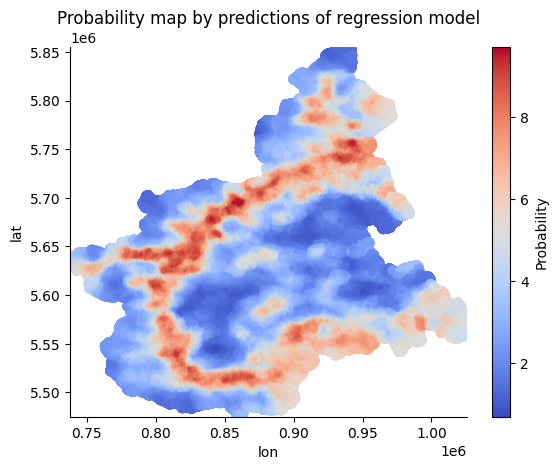

In [46]:
x = grid.geometry.x
y = grid.geometry.y
plt.scatter(x=x, y=y, c=values_r, cmap='coolwarm')
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar(label='Probability')
plt.title('Probability map by predictions of regression model')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(x.min()-0.2, x.max()+0.2)
ax.set_ylim(y.min()-0.2, y.max()+0.2)

plt.show()

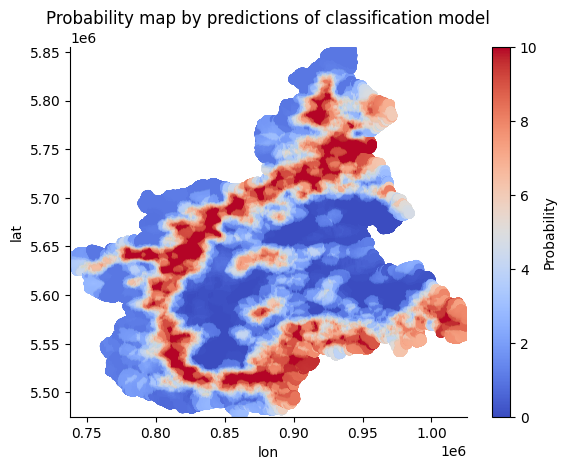

In [47]:
x = grid.geometry.x
y = grid.geometry.y
plt.scatter(x=x, y=y, c=values_c, cmap='coolwarm')
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar(label='Probability')
plt.title('Probability map by predictions of classification model')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(x.min()-0.2, x.max()+0.2)
ax.set_ylim(y.min()-0.2, y.max()+0.2)

plt.show()